## Clustering II: El problema de Santiago
### Problema:
El problema consiste en segmentar imágenes de células sanguíneas. 
Note que cada imagen se puede ver como un tensor de 3 capas (n x m x 3), cada capa correspondiente al color  rojo, verde y azul. Por lo tanto, cada imagen puede verse como un dataset donde cada fila corresponde a los valores rojo, verde y azul de un pixel de la imagen, es decir el dataset es una matriz de $m\times n$ filas y 3 columnas. Para lograr  la segmentación de una imágen se propone la siguiente metodología:
1.  Extraer de las imágenes la información de cada pixel tal que se obtenga la matriz de información por pixeles de dimención ($mn\times 3$)
2. Aplicar k-means como técnica de agrupamiento para encontrar los pixeles similares por su color

3. Determinar el mejor valor de k, que corresponde al número de regiones de la segmentación

4. Reconstruir cada imagen con color de centroides

## Cargamos la base de datos con las imágenes de las células

In [136]:
import numpy as np
import os
import skimage
from skimage import io
from sklearn.cluster import KMeans
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
#plt.rcParams["axes.grid"] = False
import seaborn as sns
sns.set()

In [2]:
files = os.listdir("./data_test/")[1:]
data = []
for i in range(1,len(files)+1):
    data.append(io.imread("./data_test/"+str(i)+".jpg"))
    
# Ahora todas las imagenes están en la lista data

## 1.  Extraer de las imágenes la información de cada pixel
 Así obtenemos una matriz de información por pixeles de dimención ($mn\times 3$).

In [4]:
def img_to_matrix(img):
    """
    Transforma la información de una imagen de dimensiones (m,n,3) a una matriz de tamaño (mn x 3) con información de pixeles
    
    args:
        img: imagen a color
    
    retorna:
        matriz de tamaño (mn x 3)
    """
    m = img.shape[0]
    n = img.shape[1]
    row = 0
    mat = np.zeros([m*n,3]) # alocating memory
    for i in range(m):
        for j in range(n):
            mat[row,:] = img[i,j,:]
            row+=1
    return mat

In [34]:
# Probando con la primera imagen
X = img_to_matrix(data[0])
X

array([[192., 160., 165.],
       [191., 159., 164.],
       [193., 158., 164.],
       ...,
       [200., 168., 173.],
       [203., 171., 174.],
       [205., 173., 176.]])

## Graficas de como se ven los puntos

In [152]:
def scatter_3d(X,Y,Z):
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.scatter(X,Y,Z,marker='o')
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")
    plt.show()

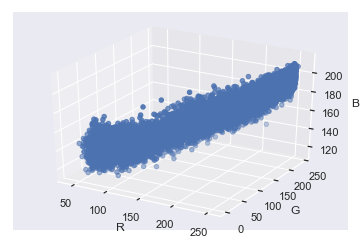

In [153]:
scatter_3d(X[:,0],X[:,1],X[:,2])

## 2. Aplicar k-means
Así se agrupa los pixeles similares por su color.

In [21]:
def iterate_K(X,max_groups):
    """
    Calcula la suma de errores cuadráticos (SSE) para un valores de k de 1 hasta max_groups
    
    args:
        X: matriz de datos
        max_groups: número máximo de grupos con el que se prueba
        
    returna:
        la lista de ks de 1 hasta max_groups, la lista de SSE para cada k y un diccionario con sus modelos asociados
    """
    sse = []
    models = {}
    for k in range(1,max_groups+1):
        models[k] = KMeans(init="random",n_clusters=k,random_state=42)
        models[k].fit(X)
        sse.append(models[k].inertia_)
    return range(1,max_groups+1), sse, models

## 3. Determinar el mejor valor de k
El mejor valor k corresponde al número de regiones de la segmentación.

https://realpython.com/k-means-clustering-python/

In [23]:
# Calculamos los SSE para cada grupo
max_gr = 7
ks_1, sse_1, km_models_1 = iterate_K(X,max_gr)

Graficamos la evolución de el SSE en función de los valores k.

In [22]:
def elbow_plot(ks, sse):
    ax = sns.lineplot(x=ks_1,y=sse_1)
    ax.set(xlabel="k", ylabel="SSE")
    return ax

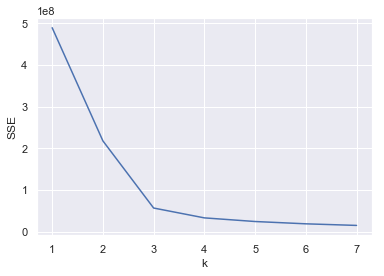

In [24]:
ax = elbow_plot(ks_1, sse_1)

De la gráfica anterior podemos ver que el mejor k en el cual se hace un mejor agrupamiento es con k = 3.

## 4. Reconstruimos la imagen de las células

In [97]:
def segment_img(X,modelos,original,k):
    """
    Segmenta una imagen con numero de grupos de k means elegido
    args:
        X: matriz de datos RGB de la imagen original
        modelos: diccionario de modelos de k-means 
        original: imagen original
        k: mejor  numero de grupos seleccionado
    returns:
        imagen segmentada
    """
    row = 0
    img = np.copy(original)
    c = 255./k
    colores = np.random.randint(0,255,[4,3])
    for i in range(original.shape[0]):
        for j in range(original.shape[1]):
            for n in range(k):
                if modelos[k].labels_[row] == n:
                    img[i,j,:] =  colores[n]#n*c*np.array([1,0,0]) #model.cluster_centers_[0]
                    break
            row = row + 1
    return img

        

In [134]:
img_r_1 = segment_img(X,km_models_1,data[0],3) 

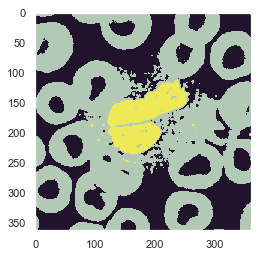

In [135]:

plt.imshow(img_r_1)
plt.grid(None)
#plt.plot(img_r_1)

# Aplicación de metodología a todas las imagenes

In [ ]:
Xs = dict{} # diccionarios con parejas (i, Matriz de datos de datos de i-esima imagen)
for i in range(len(data)):
    Xs[i] = img_to_matrix(data[i])
    

In [ ]:
## Corregir con dilatacion y erosion, o filtro pasabajos